<a href="https://colab.research.google.com/github/adonaiarruda/rl-2021/blob/main/Labs/QLearning_DQN_Lab_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Q-Learning & Deep Q Network - Lab 02


Nesse laboratório iremos abordar sobre os temas: OpenAI Gym, Q-learning e DQN. Você irá encontrar descrições e referências sobre os temas abordados. 

Atente-se em encontrar os `# HW` nos códigos! Eles irão definir as tarefas que você deverá realizar afim de completar o código.

Quaisquer dúvidas que tiverem, procurem mandar no canal `# dúvidas-labs` no Discord. Lembrando que às quintas-feiras a partir das 19h estaremos no canal `Sala-de-estudo` para tirar suas dúvidas e auxiliar em eventuais erros de execução no notebook.


## Configuração 

Você precisará fazer uma cópia deste notebook em seu Google Drive antes de editar. Você pode fazer isso com **Arquivo → Salvar uma cópia no Drive**.

In [1]:
from collections import namedtuple, deque
import os
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# Seu trabalho será armazenado em uma pasta chamada `minicurso_rl` por padrão 
# para evitar que o tempo limite da instância do Colab exclua suas edições


DRIVE_PATH = "/content/gdrive/My\ Drive/minicurso_rl/lab02"
DRIVE_PYTHON_PATH = DRIVE_PATH.replace("\\", "")
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

SYM_PATH = "/content/minicurso_rl"
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [3]:
!pip install "gym[all]"  > /dev/null 2>&1 
!pip install "gym[box2d]"  > /dev/null 2>&1 
!pip install box2d-py > /dev/null 2>&1 

!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!pip install pyvirtualdisplay > /dev/null 2>&1

!pip install plotly > /dev/null 2>&1
!pip install --upgrade ceia-soccer-twos > /dev/null 2>&1

In [4]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/ -y
! python -m atari_py.import_roms /content/ROM/ > /dev/null 2>&1

--2021-10-21 13:34:25--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   637KB/s    in 18s     

2021-10-21 13:34:43 (615 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK


In [5]:
import random
import numpy as np
import torch
from torch import nn


torch.manual_seed(10)
random.seed(10)
np.random.seed(10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

## OpenAI GYM



O [OpenAI Gym](https://gym.openai.com/) visa fornecer um benchmark fácil de configurar com uma ampla variedade de ambientes diferentes. O objetivo é padronizar como os ambientes são definidos nas publicações de pesquisa de IA para que as pesquisas publicadas se tornem mais facilmente reprodutíveis. O projeto pretende fornecer ao usuário uma interface simples.


A peça central do Gym é o ambiente, que define o "jogo" em que seu algoritmo de reforço competirá. Um ambiente não precisa ser um jogo; no entanto, ele descreve os seguintes recursos semelhantes aos de um jogo:

- **Espaço de ação**: Quais ações podemos realizar no ambiente, a cada etapa / episódio, para alterar o ambiente.
- **Espaço de observação**: Qual é o estado atual da parte do ambiente que podemos observar. Normalmente, podemos ver todo o ambiente.


Antes de começarmos a examinar o Gym, é essencial entender um pouco da terminologia usada por esta biblioteca.

- **Agent** - o programa ou modelo de aprendizado de máquina que controla as ações. 
- **Step** - Uma rodada de ações que afetam o estado do ambiente.
- **Episode** - Uma coleção de steps que termina quando o agente cumpre ou falha em cumprir o objetivo do ambiente ou o episódio atinge o número máximo de etapas permitidas.
- **Reward** - Reforço positivo/negativo que pode ocorrer ao final de cada episódio ou após cada ação do agente.
- **Render** - O Gym pode renderizar um quadro para exibição após cada episódio.
- **Nondeterministic** - para alguns ambientes, a aleatoriedade é um fator na decisão de quais efeitos as ações têm na recompensa e nas mudanças no espaço de observação.


A biblioteca Gym nos permite consultar alguns desses atributos de ambientes.

In [7]:
import gym

def query_environment(name):
    
  env = gym.make(name)
  spec = gym.spec(name)

  print(f"Action Space: {env.action_space}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")

Começaremos examinando o ambiente `MountainCar-v0`, que desafia um carro a escapar do vale entre duas montanhas. 


Existem três ações distintas que podem ser tomadas: acelerar para frente, desacelerar ou acelerar para trás. O espaço de observação contém dois valores contínuos (ponto flutuante), conforme evidenciado pelo objeto Box. O espaço de observação é simplesmente a posição e a velocidade do carro. O carro tem 200 steps para escapar do vale a cada episódio. Você teria que olhar o código para saber, mas o carro não recebe qualquer recompensa incremental. A única recompensa é dada quando o carro foge do vale.

In [8]:
query_environment("MountainCar-v0")

Action Space: Discrete(3)
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: -110.0


O ambiente `CartPole-v1` desafia o agente a mover um carrinho sobre um trilho enquanto mantém um mastro equilibrado. O ambiente possui um espaço de observação de 4 números contínuos:

- Posição do carrinho
- Velocidade do carrinho
- Ângulo do mastro
- Velocidade do mastro na ponta

Para atingir esse objetivo, o agente pode realizar as seguintes ações:

- Empurre o carrinho para a esquerda
- Empurre o carrinho para a direita


In [45]:
query_environment("CartPole-v1")

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Max Episode Steps: 500
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 475.0


Também existe uma variante contínua do carro de montanha. Esta versão não possui simplesmente o motor ligado ou desligado. Para o carro contínuo, o espaço de ação é um único número de ponto flutuante que especifica quanta força para frente ou para trás está sendo aplicada.

In [10]:
query_environment("MountainCarContinuous-v0")

Action Space: Box([-1.], [1.], (1,), float32)
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Max Episode Steps: 999
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 90.0


Os jogos do Atari, como o Breakout, podem usar um espaço de observação que é igual ao tamanho da tela do Atari (210x160) ou até mesmo usar a memória RAM do Atari (128 bytes) para determinar o estado do jogo.

In [11]:
query_environment("Breakout-v0")

Action Space: Discrete(4)
Observation Space: Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255

In [12]:
query_environment("Breakout-ram-v0")

Action Space: Discrete(4)
Observation Space: Box([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255], (128,), uint8)
Max Episode Steps: 10000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None


Você pode verificar outras classes de ambientes disponíveis como Algorithmic, Atari, Box2D e Robotics [aqui](https://gym.openai.com/envs/#algorithmic).

Quando o agente interage com o ambiente através de uma ação, a função `step(action)` retorna uma tupla contendo a observação do próximo estado do ambiente, um sinal contínuo de recompensa, um sinal booleano de finalização de episódio (*done*), e um dicionário com informações extras para depuração.

<img src='https://drive.google.com/uc?id=1TXdjYkbfm2EvtCbVIpe5BkUgXJY1d1zE' width="600" height="250">

In [13]:
env = gym.make('MountainCarContinuous-v0') # tente para ambientes diferentes
observation = env.reset()

for t in range(3):
    print("\n----------")
    print("Observation: ", observation)
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    print("Next Observation: ", observation)
    print("Reward: ", reward)
    print("Done: ", done)
    print("Info: ", info)
    if done:
        print("Finished after {} timesteps".format(t+1))
        break


----------
Observation:  [-0.46552728  0.        ]
Next Observation:  [-0.46599683 -0.00046955]
Reward:  -5.829295610624286e-05
Done:  False
Info:  {}

----------
Observation:  [-0.46599683 -0.00046955]
Next Observation:  [-4.66236612e-01 -2.39779398e-04]
Reward:  -0.019338919792497578
Done:  False
Info:  {}

----------
Observation:  [-4.66236612e-01 -2.39779398e-04]
Next Observation:  [-4.66685584e-01 -4.48972191e-04]
Reward:  -0.002129715875542204
Done:  False
Info:  {}


# Q-Learning

O Q-Learning é uma técnica fundamental de aprendizagem por reforço que é capaz de encontrar uma política ótima para um Processo de Decisão de Markov Finito, dado um número suficiente de iterações com o ambiente. O Q-Learning funciona construindo uma tabela que relaciona o valor de uma ação para cada estado possível.

### Ambiente

O ambiente utilizado será o [Taxi-v3](https://gym.openai.com/envs/Taxi-v3/).

Existem 4 locais (R, G, Y, B) e o nosso objetivo é que o táxi pegue o passageiro no local certo e o desembarque no local correto. Para garantir que nosso agente se comporte dessa forma, temos uma recompensa de -1 para cada ação e uma recompensa adicional de +20 por entregar o passageiro. Há também uma recompensa de -10 por executar ações de “coleta” e “entrega” ilegalmente.

<br>

#### Ações

Existem 6 ações determinísticas discretas:
- 0 = mover para o sul (south)
- 1 = mover para o norte (north)
- 2 = mover para o leste (east)
- 3 = mover para o oeste (west)
- 4 = embarque de passageiro (pickup)
- 5 = desembarque de passageiro (dropoff)


<br>

#### Observações

A observação é dada por uma grade 5x5 que representa o mapa e a posição dos objetos no mesmo.

<br>

Locais de passageiros:

[R]ed = 0, [Y]ellow = 1, [G]reen = 2, [B]lue = 3, Passageiro no táxi (o táxi fica com a cor verde) = 4.

<br>

Locais de entrega:

[R]ed = 0, [Y]ellow = 1, [G]reen = 2, [B]lue = 3. 


<br>


Há quatro (4) destinos e cinco (4 + 1) locais de passageiros. Então, existem 5 x 5 x 4 x 5 = 500 estados discretos possíveis.


Também podemos ver que uma letra azul indica a localização atual do passageiro, a cor rosa indica o local de desembarque, o táxi é amarelo e fica verde quando há um passageiro nele, '|' indica as paredes.


In [14]:
# Procedimento para renderizar o ambiente 

from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.5)
        

In [15]:
import gym

In [16]:
environment_id = "Taxi-v3"
env = gym.make(environment_id)

In [17]:
query_environment(environment_id)

Action Space: Discrete(6)
Observation Space: Discrete(500)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 8


In [18]:
frames = []
episodes = 1
for episode in range(1, episodes+1):
    obs = env.reset()     # Retorna a observação inicial
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()            # Seleciona uma ação aleatória
        obs, reward, done, info = env.step(action)    # Executa a ação selecionada
        score += reward

        frames.append({
            "frame": env.render(mode="ansi"),
            "state": obs,
            "action": action,
            "reward": reward
            }
        )
    print("\n\nEpisódio: {} Pontuação: {}".format(episode,score))
env.close()



Episódio: 1 Pontuação: -821


In [19]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Timestep: 200
State: 328
Action: 1
Reward: -1


### Q-Learning

Essencialmente, o Q-learning permite que o agente use as recompensas do ambiente para aprender, com o tempo, a melhor ação a ser executada em um determinado estado.

Agora, inicializamos a tabela Q como um dicionário que armazena o par estado-ação especificando o valor de realizar uma ação *a* no estado *s*.

In [20]:
q = {}
for s in range(env.observation_space.n):
    for a in range(env.action_space.n):
        q[(s,a)] = 0.0

Um valor Q para uma determinada combinação de estado-ação é representativo da "qualidade" de uma ação realizada a partir desse estado. Melhores valores de Q implicam em melhores chances de obter maiores recompensas.

Os valores Q são inicializados com um valor arbitrário e, conforme o agente se expõe ao ambiente e recebe diferentes recompensas ao executar ações diferentes, os valores Q são atualizados usando a equação:

<br>

$Q(state, action) \leftarrow (1 - \alpha) Q(state, action) + \alpha(reward + \gamma \max\limits_{a} Q(nextState, allActions))$


<br>

Definimos uma função chamada `update_q_table` que irá atualizar os valores Q de acordo com a regra de atualização do Q-Learning.

In [21]:
# HW construa a função update_q_table seguindo a equação mostrada acima
def update_q_table(prev_state, action, reward, next_state, alpha, gamma):
    # Calcule max_a Q(next_state, all_actions) procurando na tabela Q quais 
    # ações para o estado next_state possuem o maior valor Q
    d = {}
    for a in range(env.action_space.n):
      d[a] = q[(next_state,a)]
    max_a = max(d,key=d.get)
    # DUVIDA: ACHAR FORMA MELHOR DE FAZER ESSA ITERAÇÃO 
    # -> pista da ultima celula: action = max(list(range(env.action_space.n)), key = lambda x: q[(prev_state,x)])
  
    # Atualize a tabela Q na posição (prev_state, action) conforme a regra de atualização
    # (1-alpha) * Q(prev_state, action) + alpha(reward + gamma * max_a Q(next_state, all_actions))
    
    # Outra forma de escrever essa equação:
    # Q(prev_state, action) <- Q(prev_state, action) + alpha(reward + gamma * max_a Q(next_state, all_actions) - Q(prev_state, action))
    current_q = q[(prev_state, action)]
    q[(prev_state, action)] = current_q + alpha * (reward + gamma * q[(next_state, max_a)] - current_q)

    # DUVIDA: essa função precisa retornar o q ou o valor de q?



Em seguida, definimos uma função para executar a política epsilon-greedy. Na política epsilon-greedy, selecionamos a melhor ação com probabilidade `1 - epsilon` ou exploramos uma nova ação (aleatória) com probabilidade `epsilon`.

In [22]:
# HW construa a função epsilon_greedy_policy seguindo a descrição acima
def epsilon_greedy_policy(state, epsilon):
    # Você pode utilizar a função random.uniform para amostrar um valor 
    # aleatório entre 0 e 1. Caso o valor amostrado seja menor do que epsilon
    # retorne uma ação aleatória. Caso contrário retorne a ação que maximiza o 
    # valor Q para o estado state
    if np.random.random() < epsilon:
      action = np.random.randint(0, env.action_space.n)
    else:
      d = {}
      for a in range(env.action_space.n):
        d[a] = q[(state,a)]
      action = max(d,key=d.get)

    return action


Agora inicializamos as variáveis necessárias

`alpha` - taxa de aprendizagem ($0 < \alpha \leq 1$)

`gamma` - fator de desconto ($0 < \gamma \leq 1$)

`epsilon` - valor epsilon na política epsilon-greedy ($0 < \epsilon < 1$)

In [23]:
alpha = 0.7
gamma = 0.6
epsilon = 0.1

Agora, vamos realizar o Q-Learning !

In [24]:
from IPython.display import clear_output

epochs = 8000
all_rewards = []
for i in range(epochs):
    r = 0
    done = False

    prev_state = env.reset()
    
    while not done:
                
        # HW: selecione a ação pela política epsilon-greedy
        action = epsilon_greedy_policy(prev_state, epsilon)
        
        # HW: Realize a ação no ambiente e receba o próximo estado, recompensa, done e info
        next_state, reward, done, info = env.step(action)

        # HW: Atualize o valor Q usando a função update_q_table    
        update_q_table(prev_state, action, reward, next_state, alpha, gamma)
        # Duvida: não seria melhor retornar o new_q? 
        
        # HW: Atualize o estado anterior como próximo estado
        prev_state = next_state

        # Armazene todas as recompensas obtidas
        r += reward

    all_rewards.append(r)

    if i % 10 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print("total reward: ", r)

env.close()

Episode: 7990
total reward:  3


In [25]:
import plotly.graph_objs as go

fig = go.Figure([
    go.Scatter(
        y=all_rewards,
        x=[ep for ep in range(1, epochs + 1)],
        mode="lines",
        name="Recompensa"
    ),
])
fig.update_layout(
    title="Recompensa por episódio",
    yaxis = dict(
        title = "Recompensa"
    ),
    xaxis = dict(
        title = "Episódio",
    )
)
fig.show()

In [26]:
# Todo: Entender o alto ruído

In [27]:
import pickle

In [28]:
# Salva os dados (Tabela Q)
# pickle.dump(q, open("minicurso_rl/lab02/q_table.pkl", "wb"))

# del q

# todo: Descobrir erro do pickle

In [29]:
# Carrega os dados salvos
# q = pickle.load(open("minicurso_rl/lab02/q_table.pkl", "rb"))

Finalmente, vamos testar o quão bem o Q-learning se saiu.

In [30]:
frames = []
episodes = 1
done = False
for episode in range(1, episodes+1):
    r = 0
    prev_state = env.reset()

    while not done:
        action = max(list(range(env.action_space.n)), key = lambda x: q[(prev_state,x)])
        next_state, reward, done, _ = env.step(action)    

        r += reward

        frames.append({
            "frame": env.render(mode="ansi"),
            "state": prev_state,
            "action": action,
            "reward": reward
            }
        )

        prev_state = next_state

    print("\n\nEpisódio: {} Pontuação: {}".format(episode,r))





Episódio: 1 Pontuação: 13


In [31]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 8
State: 16
Action: 5
Reward: 20


In [32]:
del q

#Deep Q Network

No Q-Learning, representamos o valor Q como uma tabela. No entanto, em muitos problemas do mundo real, teremos enormes espaços de estado e / ou ação e a representação tabular é insuficiente. Por exemplo, Computer Go tem $10^{170}$ estados possíveis e jogos como Breakout tem um espaço de estados contínuo (intensidade dos pixeis na tela). Quando é impossível armazenar todas as combinações possíveis de valores de estado e ação na matriz 2D ou tabela Q, precisamos usar Deep Q-Network (DQN) em vez do algoritmo Q-Learning.*

*Em alguns casos é possível lidar com estados/ações contínuas agrupando esses valores em intervalos.

<img src="https://media.wired.com/photos/5955b2e6ad90646d424bb3cb/master/pass/GettyImages-475383836.jpg" height="300"> <img src="https://i.ytimg.com/vi/1oATuwG_dsA/hqdefault.jpg" height="300" width="250">

> Computer Go (esquerda) e Atari Breakout (direita)

### Ambiente

O ambiente utilizado nesta parte será o [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/).

A plataforma de pouso está sempre nas coordenadas (0,0). As coordenadas são os primeiros dois números no vetor de estado. A recompensa por pousar é de cerca de 100..140 pontos. Se o módulo de pouso se afastar da plataforma de pouso, ele perde a recompensa de volta. O episódio termina se o módulo de pouso bater ou parar, recebendo -100 ou +100 pontos adicionais. Cada contato de solo da perna é +10. O motor principal de disparo é -0,3 pontos por frame. Quatro ações discretas disponíveis: não fazer nada, disparar motor esquerdo, disparar motor principal, disparar motor direito.


In [33]:
# Procedimento para renderizar o ambiente no Google Colab

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()


from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=60):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)

In [34]:
import gym

environment_id = "LunarLander-v2"       # Nome do ambiente utilizado
env = gym.make(environment_id)          # Criando o ambiente

query_environment(environment_id)

Action Space: Discrete(4)
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200




Episódio: 1 Pontuação: -235.53910606451655


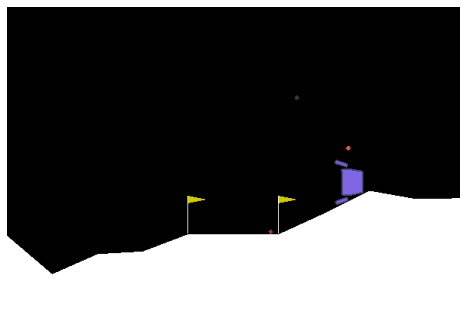

In [35]:
frames = []
episodes = 1
for episode in range(1, episodes+1):
    obs = env.reset()     # Retorna a observação inicial
    done = False
    score = 0
    while not done:
        frames.append(env.render(mode='rgb_array'))     # Renderizando o ambiente
        action = env.action_space.sample()              # Seleciona uma ação aleatória
        obs, reward, done, info = env.step(action)      # Executa a ação selecionada
        score += reward
    print("\n\nEpisódio: {} Pontuação: {}".format(episode,score))
env.close()

display.HTML(display_anim(frames))

### DQN

#### Replay Buffer

Iremos utilizar o ReplayBuffer para treinar nosso DQN. Ele armazena as transições que o agente observa, permitindo a reutilização desses dados posteriormente. Ao fazer a amostragem dele aleatoriamente, as transições que formam um batch são descorrelacionadas, ajudando a estabilizar e melhorar o treinamento do DQN.

<img src="https://production-media.paperswithcode.com/methods/b6cdb8f5-ea3a-4cca-9331-f951c984d63a_MBK7MUl.png" height="150">


In [36]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        """
        Replay memory permite que o agente registre experiências e aprenda 
        com elas.
        
        Parametros
        ---------
        buffer_size (int): tamanho máximo da memória interna
        batch_size (int): tamanho do batch que será amostrado durante o treino
        seed (int): random seed
        """

        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Adicionar experiência"""
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
                
    def sample(self):
        """ 
        Amostrar aleatoriamente e retornar a tupla (estado, ação, recompensa, 
        próximo_estado, concluído) como torch tensors
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Converter em torch tensors
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)  
        
        # Converter done de boolean para int
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

#### Algoritmo DQN

Nosso objetivo será treinar uma política que tente maximizar a recompensa cumulativa com desconto

$R_{t_0} = \sum^{\infty}_{t=t_0} \gamma^{t-t_0}r_t$ 

Onde $R_{t_0}$ também é conhecido como retorno. O deconto, $\gamma$, deve ser uma constante entre $0$ e $1$. Isso torna as recompensas de um futuro incerto e distante menos importante para nosso agente do que as recompensas de um futuro próximo em que ele pode estar bastante confiante.

A ideia principal por trás do Q-learning é que se tivéssemos uma função $Q^*: Estado \times Ação \rightarrow \mathbb{R}$ que poderia nos dizer qual seria nosso retorno, se tomássemos uma ação em um determinado estado, poderíamos facilmente construir uma política que maximizasse nossas recompensas:

$\pi^* (s) = \arg \max\limits_{a} Q^* (s, a)$


No entanto, não sabemos tudo sobre o mundo, por isso não temos acesso a $Q^*$. Mas, uma vez que as redes neurais são aproximadores universais de função, podemos simplesmente criar uma e treiná-la para se assemelhar $Q^*$.

Para nossa regra de atualização, usaremos o fato de que cada função $Q$ para alguma política obedece à equação de Bellman:

$Q^\pi(s, a) = r + \gamma Q^{\pi}(s^{'}, \pi(s^{'}))$


A diferença entre os dois lados da igualdade é conhecida como erro de diferença temporal, $\delta$:

$\delta = Q(s, a) - (r + \gamma \max\limits_{a} Q^{\pi}(s^{'}, a))$



#### Q-Network


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        """
        Construa uma rede neural fully connected
        
        Parameters
        ----------
        state_size (int): Dimensão do estado
        action_size (int): Dimensão da ação
        seed (int): random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)  
        
    def forward(self, x):
        """Forward pass"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x        

#### Treinamento

Aqui você encontra a função ```learn``` que executa uma única etapa da otimização. Ele primeiro faz uma amostra de um batch, calcula $Q(s_t, a_t)$ e $V(s_{t+1}) = \max\limits_{a}Q(s_{t+1},a)$, e os combina na nossa loss. Também utilizamos uma Target Network fixa para calcular $V(s_{t+1})$ para uma maior estabilidade. A Target Network tem seus pesos mantidos congelados na maior parte do tempo, mas é atualizada com os pesos da rede Q de vez em quando.



In [38]:
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        """
        O Agente DQN interage com o ambiente, 
        armazena a experiência e aprende com ela
        
        Parametros
        ----------
        state_size (int): Dimensão do estado
        action_size (int): Dimensão da ação
        seed (int): random seed
        """

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Inicializar redes Q 
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.fixed_network = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LR)

        # Inicializar memória
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0


    # HW defina a função de loss
    def criterion(self, predicted, target) -> torch.tensor:
        """
        Calcula o erro quadrático médio entre o valor predito e o valor alvo

        Parametros
        ----------
        predicted (torch.tensor): valor predito
        target (torch.tensor): valor alvo

        -> torch.Te
        """
        # raise NotImplementedError   
        return F.mse_loss(predicted, target)
          
    
    def step(self, state, action, reward, next_state, done):
        """
        Atualiza o conhecimento do Agente
        
        Parametros
        ----------
        state (array_like): Estado atual do ambiente
        action (int): Ação realizada no estado atual
        reward (float): Recompensa recebida após a ação
        next_state (array_like): Próximo estado retornado pelo ambiente após a ação
        done (bool): se o episódio terminou após a ação
        """

        # Salva transição no replay buffer
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1

        # Realiza o aprendizado do agente a cada UPDATE_EVERY steps
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                loss = self.learn(sampled_experiences)

                return loss
        return None
        
    def learn(self, experiences):
        """
        Aprende com a experiência treinando a q_network
        
        Parametros
        ----------
        experiences (array_like): Lista de experiências amostradas da memória do agente
        """
        states, actions, rewards, next_states, dones = experiences

        # Obtenha a ação com valor máximo de Q
        action_values = self.fixed_network(next_states).detach()

        # Notas
        # tensor.max(1)[0] retorna os valores, tensor.max(1)[1] retorna os índices
        # operação unsqueeze --> np.reshape
        # Aqui nós fazemos torch.Size([64]) -> torch.Size([64, 1])
        # O valor obtido será correspondente a max_a Q(S', a)
        max_action_values = action_values.max(1)[0].unsqueeze(1)

        # HW Defina o Q_target (Q*) com valores de ação com desconto para todas
        # as transições não finais (done == 0). Para as transições finais (done == 1)
        # Q(S', a) é 0, portanto utilize a recompensa diretamente.
        # Q*(S, A) <- r + γ max_a Q(S', a)

        q_target = self.q_network.forward(states) # Pode ser que passe para dentro do loop for
        q_target_next = elf.q_network.forward(next_states)

        for i in range(BATCH_SIZE):
          if dones[i]:
            q_target[i][actions[i]] = rewards[i]
          else:
            q_target[i][actions[i]] = rewards[i] + GAMMA * (torch.max(q_target_next[i]))
          








        # Calcula Q(s_t, a) - o modelo calcula Q (s_t), então selecionamos as 
        # colunas de ações tomadas. Estas são as ações que teriam sido tomadas 
        # para cada estado do batch de acordo com a rede Q
        Q_predicted = self.q_network(states).gather(1, actions)
        
        # HW Calcula a loss

        # HW zerar os gradientes

        # HW calcula os novos gradientes (backward pass)

        # HW atualiza os pesos com o otimizador
        
        # Atualizar pesos da rede Q fixa
        self.update_fixed_network(self.q_network, self.fixed_network)

        return loss.detach().cpu().numpy()
        
    def update_fixed_network(self, q_network, fixed_network):
        """
        Atualize a rede fixa copiando os pesos da rede Q usando o parâmetro TAU
        
        Parametros
        ----------
        q_network (PyTorch model): Q network
        fixed_network (PyTorch model): target network fixa
        """
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)
        
        
    def act(self, state, eps=0.0):
        """
        Escolha a ação
        
        Parametros
        ----------
        state (array_like): estado atual do ambiente
        eps (float): epsilon para seleção epsilon-greedy de ação
        """
        rnd = random.random()

        if rnd < eps:
            return np.random.randint(self.action_size)
        else:
            # Seleciona a melhor ação com probabilidade 1 - eps
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            # coloque a rede em modo de avaliação
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)

            # Voltar ao modo de treino
            self.q_network.train()
            action = np.argmax(action_values.cpu().data.numpy())
            return action    
        
    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

    def load_model(self, filename):
        self.q_network.load_state_dict(torch.load(filename))
        self.fixed_network.load_state_dict(torch.load(filename))


In [39]:
BUFFER_SIZE = int(1e5)  # Tamanho do Replay Buffer
BATCH_SIZE = 64         # Número de experiências para amostrar da memória
GAMMA = 0.99            # Fator de desconto
TAU = 1e-3              # Parâmetro de atualização suave para atualização de rede Q fixa
LR = 1e-4               # Taxa de aprendizagem
UPDATE_EVERY = 4        # Com que frequência atualizar a rede Q 

MAX_EPISODES = 3000  # Número máximo de episódios para jogar
MAX_STEPS = 1000     # passos máximos permitidos em um único episódio / jogo
ENV_SOLVED = 200     # Pontuação MAX em que consideramos o ambiente ser resolvido
PRINT_EVERY = 100    # Com que freqüência imprimir o progresso

# Epsilon 
EPS_START = 1.0      # Valor padrão / inicial de eps
EPS_DECAY = 0.999    # Taxa de decaimento do épsilon
EPS_MIN = 0.01       # Épsilon mínimo

Antes de começar, vamos visualizar o efeito do decaimento do epsilon

In [40]:
EPS_DECAY_RATES = [0.9, 0.99, 0.999, 0.9999]
plt.figure(figsize=(10,6))

fig = go.Figure([])

_eps_list = []
for decay_rate in EPS_DECAY_RATES:
    test_eps = EPS_START
    eps_list = []
    for _ in range(MAX_EPISODES):
        test_eps = max(test_eps * decay_rate, EPS_MIN)
        eps_list.append(test_eps)          
    
    _eps_list.append(eps_list)


fig = go.Figure([
    go.Scatter(
        y=_eps_list[0],
        x=[ep for ep in range(1, len(eps_list) + 1)],
        mode="lines",
        name=EPS_DECAY_RATES[0]
    ),
    go.Scatter(
        y=_eps_list[1],
        x=[ep for ep in range(1, len(eps_list) + 1)],
        mode="lines",
        name=EPS_DECAY_RATES[1]
    ),
    go.Scatter(
        y=_eps_list[2],
        x=[ep for ep in range(1, len(eps_list) + 1)],
        mode="lines",
        name=EPS_DECAY_RATES[2]
    ),
    go.Scatter(
        y=_eps_list[3],
        x=[ep for ep in range(1, len(eps_list) + 1)],
        mode="lines",
        name=EPS_DECAY_RATES[3]
    ),
])
fig.update_layout(
    title="Efeito de várias taxas de decaimento",
    xaxis = dict(title="# Episódios"),
    yaxis = dict(title="Epsilon")
)
fig.show()

<Figure size 720x432 with 0 Axes>

Abaixo, você encontra o ciclo principal de treinamento. No início, redefinimos e inicializamos o ambiente. Em seguida, experimentamos uma ação, executamos, observamos o próximo estado e a recompensa e otimizamos nosso modelo uma vez. Quando o episódio termina, reiniciamos o loop. 



<img src='https://drive.google.com/uc?id=1_RURPuJ9FcVM5RbHiIGRwAOSqXiMuPnw' width="620" height="300">

In [41]:
# Obtem tamanhos de estado e ação
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print("Tamanho do estado: {}, tamanho da ação: {}".format(state_size, action_size))

Tamanho do estado: 8, tamanho da ação: 4


In [42]:
dqn_agent = DQNAgent(state_size, action_size, seed=0)

In [43]:
from time import time

start = time()
scores = []
loss = []

# Mantem uma lista das últimas 100 pontuações
scores_window = deque(maxlen=100)
eps = EPS_START
for episode in range(1, MAX_EPISODES + 1):
    score = 0

    # HW inicialize o ambiente e pegue a primeira observação
    for t in range(MAX_STEPS):
        # HW: Peça para o agente (dqn_agent) escolher uma ação dado a observação e 
        # um epsilon eps

        # HW: Realize a ação no ambiente e receba o próximo estado, recompensa, done e info

        # HW: Dado o estado, ação, recompensa, próximo_estado e done obtidos, 
        # atualize o conhecimento do agente, e guarde a _loss retornada para 
        # futuros logs

        # HW: Atualize o estado anterior como próximo estado        

        score += reward        
        if done:
            break

        if _loss is not None:
            loss.append(_loss)
            
        eps = max(eps * EPS_DECAY, EPS_MIN)
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print("\r Progresso {}/{}, pontuação média:{:.2f}".format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print("\rAmbiente resolvido em {} episódios, pontuação média: {:.2f}".format(episode, mean_score), end="")
            sys.stdout.flush()
            dqn_agent.checkpoint("minicurso_rl/lab02/solved_dqn_ckpt.pth")
            break
            
    scores_window.append(score)
    scores.append(score)
    
end = time()    
print("{} segundos".format(end - start))

0.0036046504974365234 segundos


In [44]:
dqn_agent.checkpoint("minicurso_rl/lab02/last_dqn_ckpt.pth")

FileNotFoundError: ignored

In [ ]:
fig = go.Figure([
    go.Scatter(
        y=scores,
        x=[ep for ep in range(1, len(scores) + 1)],
        mode="lines",
        name="Recompensa"
    ),
])
fig.update_layout(
    title="Recompensa",
    xaxis = dict(title="Episódios")
)
fig.show()

In [ ]:
fig = go.Figure([
    go.Scatter(
        y=loss,
        x=[ep for ep in range(1, len(loss) + 1)],
        mode="lines",
        name="Loss"
    ),
])
fig.update_layout(
    title="Loss",
    xaxis = dict(title="Episódio")
)
fig.show()

Agora com o nosso agente já treinado, vamos ver a sua performance.

In [ ]:
dqn_agent = DQNAgent(state_size, action_size, seed=0)
dqn_agent.load_model()

In [ ]:
frames = []
episodes = 1
for episode in range(1, episodes+1):
    obs = env.reset()     
    done = False
    score = 0
    while not done:
        frames.append(env.render(mode='rgb_array'))     
        action = dqn_agent.act(obs, 0)
        obs, reward, done, info = env.step(action)      
        score += reward
    print("\n\nEpisódio: {} Pontuação: {}".format(episode,score))
env.close() 

In [ ]:
display.HTML(display_anim(frames))

# Bônus



Como vimos, o DQN é capaz de treinar uma política para atuar sobre um ambiente com observação contínua e ações discretas. Esse é o caso da variação `team_vs_policy` do ambiente `soccer_twos`, que será utilizado na competição final deste curso*.

Este ambiente consiste em um jogo de futebol de carros 2x2, ou seja, o objetivo é marcar um gol no adversário o mais rápido possível. Na variação `team_vs_policy`, seu agente controla os jogadores do time azul e joga contra uma política aleatória.

**Sua tarefa é treinar um agente com DQN para jogar contra esta política aleatória.**

<img src="https://raw.githubusercontent.com/bryanoliveira/soccer-twos-env/master/images/screenshot.png" height="400">

> Visualização do ambiente

Mais informações sobre o ambiente podem ser encontradas [aqui](https://github.com/Unity-Technologies/ml-agents/blob/main/docs/Learning-Environment-Examples.md#soccer-twos).

<br>

<small>
*A variação utilizada na competição será a `multiagent_player`, mas agentes treinados para `team_vs_policy` podem ser facilmente adaptados.
</small>

Utilize o ambiente instanciado abaixo para executar o algoritmo de treinamento. Ao final da execução, a recompensa do seu agente por episódio deve tender a +2.

In [ ]:
import soccer_twos

# Fecha o ambiente caso tenha sido aberto anteriormente
try:
    env.close()
except:
    pass

env = soccer_twos.make(variation=soccer_twos.EnvType.team_vs_policy, flatten_branched=True)

# Obtem tamanhos de estado e ação
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print("Tamanho do estado: {}, tamanho da ação: {}".format(state_size, action_size))